In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import pearsonr
df = pd.read_csv("speeches.csv.tar.gz")

/tmp/ipykernel_2554109/2820744744.py:5: DtypeWarning: Columns (11,12,13,14,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("speeches.csv.tar.gz")


In [2]:
countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES-CT", "ES-GA", "ES-PV", "ES", "FI", "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA", ]
latitudes = [ 47.33, 44, 50.83, 43, 49.75, 56, 59, 40, 40, 40, 40, 64, 46, 54, 39, 45.17, 47, 65, 42.83, 57, 52.5, 62, 52, 39.5, 44, 62, 46, 39, 49,]
mapper = {k: v for k, v in zip(countries, latitudes)}

In [3]:


# Filtering
# Keep only MPs
c1 = df.Speaker_MP == "MP"

# Exclude non-national parliaments:
c2 = ~df.country.isin(["ES-CT", "ES-GA", "ES-PV", ])

# Exclude chairs:
c3 = df.Speaker_role != "Chairperson"

ndf = df[
    c1 & \
    c2 & \
    c3
    ]

def map_sentiment_to_category(logit: float) -> str:
    if logit < 2:
        return "Negative"
    elif 2 <= logit < 4:
        return "Neutral"
    else:
        return "Positive"
ndf["sentiment_categorical"] = ndf.logits_pondered.apply(map_sentiment_to_category)


def percentage_of_neutral(l: pd.Series) -> float:
    return (l == "Neutral").sum()/l.shape[0]
def percentage_of_negative(l: pd.Series) -> float:
    return (l == "Negative").sum()/l.shape[0]
def percentage_of_positive(l: pd.Series) -> float:
    return (l == "Positive").sum()/l.shape[0]
def get_female_average_per_country(df: pd.DataFrame, country: str)-> float:
    c1 = df.country == country
    c2 = df.Speaker_gender


gb1 = ndf.groupby("country").agg({
    "logits_pondered": "mean",
    "sentiment_categorical": [percentage_of_positive, percentage_of_neutral, percentage_of_negative]
}).reset_index()
gb1.columns = "country average_sentiment percentage_of_positive percentage_of_neutral percentage_of_negative".split()



gb2 = df.groupby(["country", "Speaker_gender"]).agg({
    "logits_pondered": "mean"
}).reset_index()

gb1["latitude"] = [mapper.get(i) for i in gb1.country]
gb1["PIGS"] = gb1.country.isin(["PT", "IT", "GR", "ES"])
gb1

/tmp/ipykernel_2554109/2084864659.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf["sentiment_categorical"] = ndf.logits_pondered.apply(map_sentiment_to_category)


,country,average_sentiment,percentage_of_positive,percentage_of_neutral,percentage_of_negative,latitude,PIGS
0,AT,2.131530,0.031352,0.474208,0.494440,47.33,False
1,BA,2.213168,0.047828,0.511696,0.440476,44.00,False
2,BE,2.006709,0.043629,0.410949,0.545422,50.83,False
3,BG,2.264898,0.072697,0.513357,0.413946,43.00,False
4,CZ,2.154137,0.028028,0.507194,0.464778,49.75,False
5,DK,1.998965,0.035374,0.436198,0.528429,56.00,False
6,EE,1.832211,0.011920,0.377429,0.610651,59.00,False
7,ES,1.905895,0.057296,0.357545,0.585160,40.00,True
8,FI,2.257844,0.043077,0.540796,0.416127,64.00,False
9,FR,2.273828,0.052954,0.592533,0.354513,46.00,False


PearsonRResult(statistic=-0.4411424760035955, pvalue=0.02407703372156622)

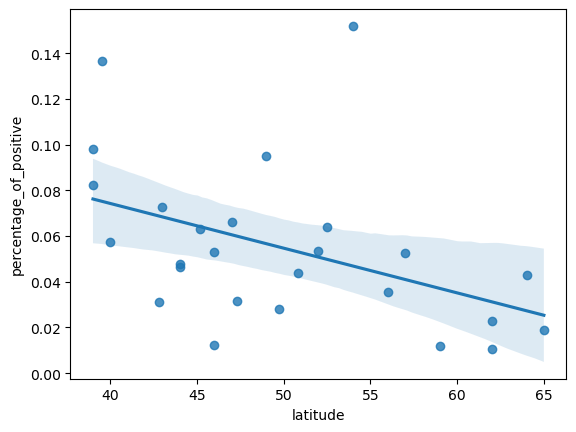

In [4]:


sns.regplot(
    data=gb1,
    x="latitude",
    y="percentage_of_positive",
    # hue="PIGS"
    # kind="scatter",
)


pearsonr(
    gb1.latitude,
    gb1.percentage_of_positive,

)

PearsonRResult(statistic=-0.1522438555096822, pvalue=0.45780873485302886)

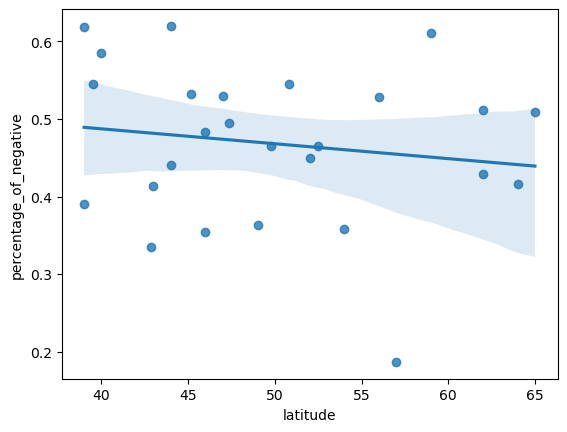

In [5]:
sns.regplot(
    data=gb1,
    x="latitude",
    y="percentage_of_negative",
    # hue="PIGS"
    # kind="scatter",
)

pearsonr(
    gb1.latitude,
    gb1.percentage_of_negative,

)

PearsonRResult(statistic=0.30650188130858363, pvalue=0.1277786099896137)

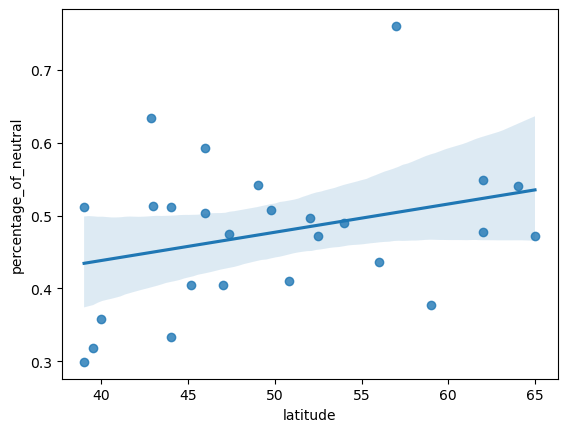

In [6]:
sns.regplot(
    data=gb1,
    x="latitude",
    y="percentage_of_neutral",
    # hue="PIGS"
    # kind="scatter",
)

pearsonr(
    gb1.latitude,
    gb1.percentage_of_neutral,

)